In [32]:
# Load packages
import os
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [33]:
path = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/intermediate/call_reports_wrds'

# set path as working directory:
os.chdir(path)

In [34]:
# load fredgraph data:
aggregates = pd.read_csv('fredgraph.csv')

# rename some variables
aggregates.rename(columns = {'DATE':'Date', 
                             'NGDPSAXDCUSQ': 'Nominal GDP', 
                             'CPIAUCSL_NBD19840101': 'CPI',
                             'GDPDEF': 'Deflator'}, inplace = True)

# drop the first row:
aggregates = aggregates.iloc[1:,:]

# for all entries with '.' substitute with NaN:
aggregates = aggregates.replace('.', np.nan)

# make 'Deflator' and 'Nominal GDP' floats:
aggregates['Deflator'] = aggregates['Deflator'].astype(float)
aggregates['Nominal GDP'] = aggregates['Nominal GDP'].astype(float)
aggregates['FEDFUNDS'] = aggregates['FEDFUNDS'].astype(float)
aggregates['CPI'] = aggregates['CPI'].astype(float)

# make 'Date' a datetime object:
aggregates['Date'] = pd.to_datetime(aggregates['Date'])

# create 'Real GDP' variable:
aggregates['Real GDP'] = aggregates['Nominal GDP'] / aggregates['CPI'] * 100

# adjust the FF rate: 
aggregates['FEDFUNDS'] = aggregates['FEDFUNDS'] / 100
aggregates['Date'] = aggregates['Date'] - pd.DateOffset(days = 1)

In [35]:
# compute the growth rate of Nominal GDP and the Deflator:
aggregates['Growth Rate Nominal GDP'] = aggregates['Nominal GDP'].pct_change(fill_method=None)
aggregates['Growth Rate Deflator'] = aggregates['Deflator'].pct_change(fill_method=None)
aggregates['Growth Rate CPI'] = aggregates['CPI'].pct_change(fill_method=None)

# compute the growth rate of Real GDP by subtracting the growth rate of the Deflator from the growth rate of Nominal GDP:
aggregates['Growth Rate Real GDP'] = aggregates['Growth Rate Nominal GDP'] - aggregates['Growth Rate Deflator']

In [36]:
# load call reports data:
loans = pd.read_csv('loans_balanced_panel.csv', low_memory=False)
int_income = pd.read_csv('interest_income_balanced.csv', low_memory=False)
deposits = pd.read_csv('deposits_balanced_panel.csv', low_memory=False)

# drop duplicates from 'deposits':
deposits = deposits.drop_duplicates()

# merge the datasets
df = pd.merge(loans[['Date', 'IDRSSD', 'RCON2122', 'Flag']], deposits, 
              on=['IDRSSD', 'Date'], how='outer', suffixes=('_RCON', '_RIAD'))

# adjust the dates
df['Date'] = pd.to_datetime(df['Date'])

# create a 'Flag' that is zero if both are zero, and 1 if either is 1:
df['Flag'] = np.where(df['Flag_RCON'] + df['Flag_RIAD'] > 0, 1, 0)

# drop the two flag columns:
df = df.drop(columns=['Flag_RCON', 'Flag_RIAD'])

# drop the RSSDID of banks with Flag = 1:
banks_flag = df[df['Flag']==1]['IDRSSD'].unique()
df = df[~df['IDRSSD'].isin(banks_flag)]

In [37]:
test = df[['IDRSSD', 'Date', 'RCON2122', 'RCON2200']].copy()
test.rename(columns = {'RCON2122': 'Loans', 'RCON2200': 'Deposits'}, inplace = True)

## Time Series 

In [38]:
# create an 'Agg. Loans' summing all the loans in a given Date:
df['Agg. Loans'] = df.groupby('Date')['RCON2122'].transform('sum')
df['Agg. Deposits'] = df.groupby('Date')['RCON2200'].transform('sum')

In [39]:
# merge df with aggregates:
df = pd.merge(df[['Date', 'IDRSSD', 'Agg. Loans', 
                  'Agg. Deposits', 'Flag']], aggregates[['Date', 'FEDFUNDS', 'Real GDP', 'Deflator', 'CPI']], on='Date', how='left')

# create aggregate real loans and deposits:
df['Agg. Real Loans'] = df['Agg. Loans'] / df['CPI'] *100
df['Agg. Real Deposits'] = df['Agg. Deposits'] / df['CPI'] *100

In [40]:
df = df[['Date', 'Agg. Real Loans', 'Agg. Real Deposits', 'FEDFUNDS', 'Real GDP', 'CPI']]

# remove duplicates:
df = df.drop_duplicates()

In [41]:
HP = 1
param = 1600

if HP == 1:

    # De-trend the variables using an HP filter:
    df['De-trended Real Loans'] = sm.tsa.filters.hpfilter(np.log(df['Agg. Real Loans']), lamb=param)[0]
    df['De-trended Real GDP'] = sm.tsa.filters.hpfilter(np.log(df['Real GDP']), lamb=param)[0]
    df['De-trended Real Deposits'] = sm.tsa.filters.hpfilter(np.log(df['Agg. Real Deposits']), lamb=param)[0]

else:
    # create a 'Time' variable grouping 'Dates':
    df['Time'] = df.groupby('Date').ngroup()

    # run regressions to detrend variables of interest 
    df['De-trended Real Loans'] = sm.OLS(np.log(df['Agg. Real Loans']), sm.add_constant(df['Time'])).fit().resid
    df['De-trended Real Deposits'] = sm.OLS(np.log(df['Agg. Real Deposits']), sm.add_constant(df['Time'])).fit().resid
    df['De-trended Real GDP'] = sm.OLS(np.log(df['Real GDP']), sm.add_constant(df['Time'])).fit().resid

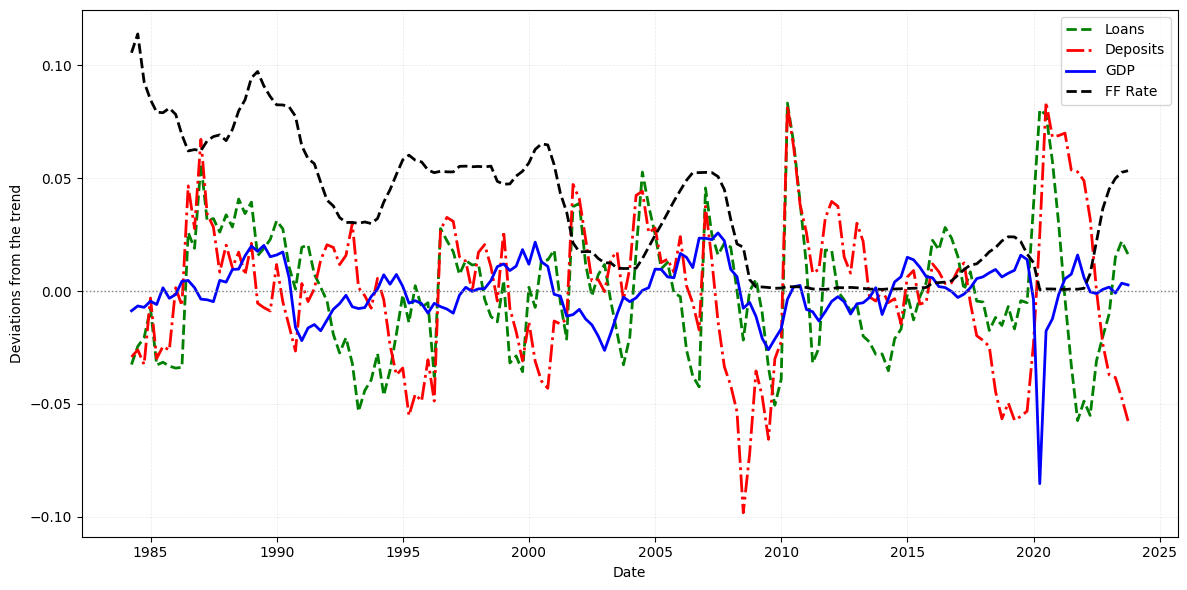

In [42]:
# plot the de-trended loans using seaborn:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='De-trended Real Loans', data=df, linewidth=2, label='Loans', color='green', linestyle='--')
sns.lineplot(x='Date', y='De-trended Real Deposits', data=df, linewidth=2, label='Deposits', color='red', linestyle='-.')
sns.lineplot(x='Date', y='De-trended Real GDP', data=df, linewidth=2, label='GDP', color='blue')
sns.lineplot(x='Date', y='FEDFUNDS', data=df, linewidth=2, label='FF Rate', color='black', linestyle='--')
# add a line at zero:
plt.axhline(y=0, color='grey', linestyle=':', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Deviations from the trend')
plt.legend()
#plt.ylim(-0.1, 0.15)
plt.tight_layout()
# add the grids:
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.show()

In [43]:
# print the correlation matrix, specifying the entries:
corr = df[['De-trended Real Loans', 'De-trended Real Deposits', 'De-trended Real GDP', 'FEDFUNDS']].corr()
print(corr)

                          De-trended Real Loans  De-trended Real Deposits  \
De-trended Real Loans                  1.000000                  0.407632   
De-trended Real Deposits               0.407632                  1.000000   
De-trended Real GDP                   -0.063559                 -0.095257   
FEDFUNDS                               0.061718                 -0.221093   

                          De-trended Real GDP  FEDFUNDS  
De-trended Real Loans               -0.063559  0.061718  
De-trended Real Deposits            -0.095257 -0.221093  
De-trended Real GDP                  1.000000  0.274233  
FEDFUNDS                             0.274233  1.000000  


In [44]:
# create a variable named 'Boom' that is 1, if the De-trended Real GDP is above 0, and 0 otherwise:
df['Recession'] = 0
df.loc[df['De-trended Real GDP'] < 0, 'Recession'] = 1

In [45]:
# print the correlation between FF rate and loans for the recession and non-recession periods:
print('Deposits:')
print('Correlation between FF rates and deposits in recessions:      ', df[df['Recession']==1]['FEDFUNDS'].corr(df[df['Recession']==1]['De-trended Real Deposits']))
print('Correlation between FF rates and deposits in booms:           ', df[df['Recession']==0]['FEDFUNDS'].corr(df[df['Recession']==0]['De-trended Real Deposits']))
print('')
print('Loans:')
print('Correlation between FF rates and loans in recessions:         ', df[df['Recession']==1]['FEDFUNDS'].corr(df[df['Recession']==1]['De-trended Real Loans']))
print('Correlation between FF rates and loans in booms:              ', df[df['Recession']==0]['FEDFUNDS'].corr(df[df['Recession']==0]['De-trended Real Loans']))

Deposits:
Correlation between FF rates and deposits in recessions:       -0.27136049395427336
Correlation between FF rates and deposits in booms:            -0.13141663775012427

Loans:
Correlation between FF rates and loans in recessions:          -0.09333014723556908
Correlation between FF rates and loans in booms:               0.23057149237848196


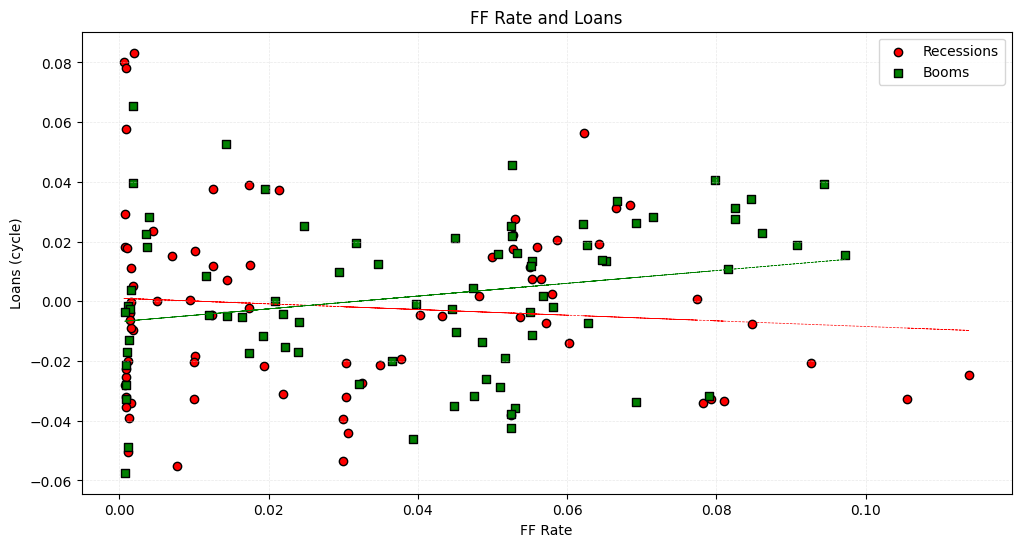

In [46]:
# make a scatter plot of the FF rate and loans for the recession and non-recession periods, using plt.scatter:
plt.figure(figsize=(12, 6))
plt.scatter(df[df['Recession']==1]['FEDFUNDS'], df[df['Recession']==1]['De-trended Real Loans'], label='Recessions', color='red', edgecolors='black')
# add a regression line:
x = df[df['Recession']==1]['FEDFUNDS']
y = df[df['Recession']==1]['De-trended Real Loans']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red', linestyle='--', linewidth=0.5)
plt.scatter(df[df['Recession']==0]['FEDFUNDS'], df[df['Recession']==0]['De-trended Real Loans'], label='Booms', color='green', edgecolors='black', marker='s')
# add a regression line:
x = df[df['Recession']==0]['FEDFUNDS']
y = df[df['Recession']==0]['De-trended Real Loans']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='green', linestyle='--', linewidth=0.5)
plt.title('FF Rate and Loans')
plt.xlabel('FF Rate')
plt.ylabel('Loans (cycle)')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.savefig('FF_Rate_Loans.svg')
plt.show()


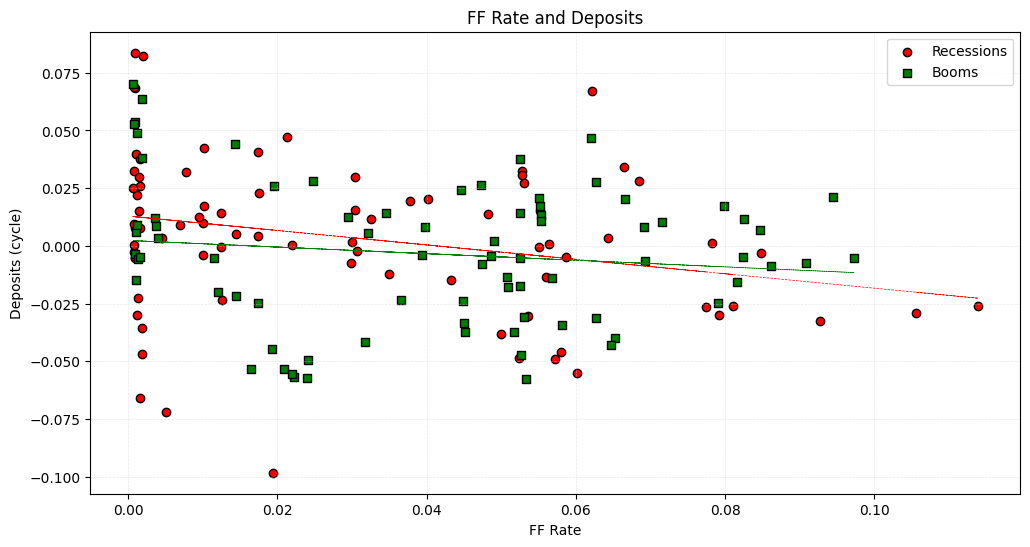

In [47]:
# make the same plot as above with 'Deposits' instead of 'Loans':
plt.figure(figsize=(12, 6))
plt.scatter(df[df['Recession']==1]['FEDFUNDS'], df[df['Recession']==1]['De-trended Real Deposits'], label='Recessions', color='red', edgecolors='black')
# add a regression line:
x = df[df['Recession']==1]['FEDFUNDS']
y = df[df['Recession']==1]['De-trended Real Deposits']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red', linestyle='--', linewidth=0.5)
plt.scatter(df[df['Recession']==0]['FEDFUNDS'], df[df['Recession']==0]['De-trended Real Deposits'], label='Booms', color='green', edgecolors='black', marker='s')
# add a regression line:
x = df[df['Recession']==0]['FEDFUNDS']
y = df[df['Recession']==0]['De-trended Real Deposits']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='green', linestyle='--', linewidth=0.5)
plt.title('FF Rate and Deposits')
plt.xlabel('FF Rate')
plt.ylabel('Deposits (cycle)')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.savefig('FF_Rate_Deposits.svg')
plt.show()

In [48]:
main = df.copy()

#### Bank Index

In [49]:
# read the 'bank index' data:
bank_index = pd.read_excel('bank index.xlsx')
bank_index['Date'] = pd.to_datetime(bank_index['Date'])
df = pd.merge(df, bank_index, on='Date', how='right')
df.rename(columns = {'Last Price':'Bank Index'}, inplace = True)

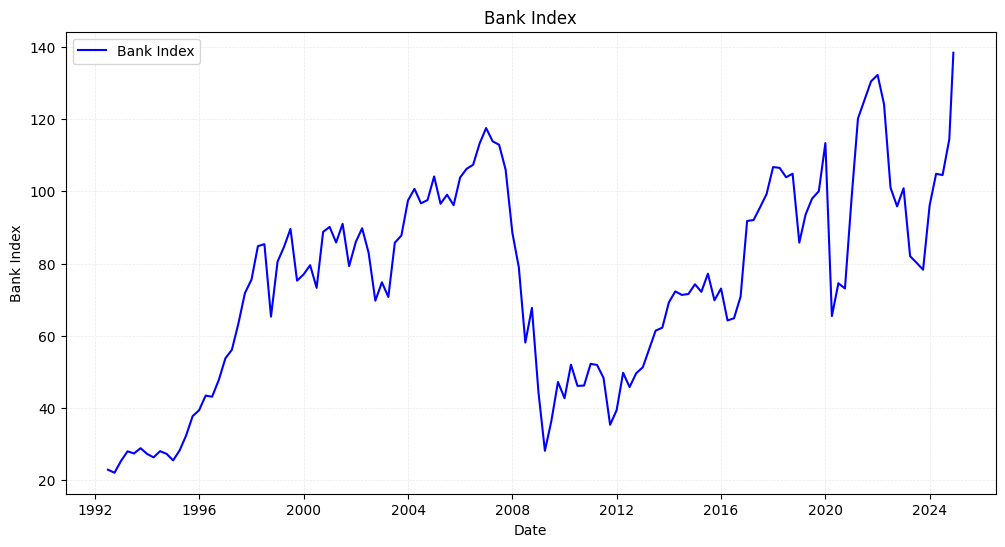

In [50]:
# plot the bank index:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Bank Index'], label='Bank Index', color='blue')
plt.title('Bank Index')
plt.xlabel('Date')
plt.ylabel('Bank Index')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')


In [51]:
# de-trend the bank index using an HP filter:
df['De-trended Bank Index'] = sm.tsa.filters.hpfilter(np.log(df['Bank Index']), lamb=param)[0]

# create the growth rate of the bank index:
df['Growth Rate Bank Index'] = df['Bank Index'].pct_change(fill_method=None)

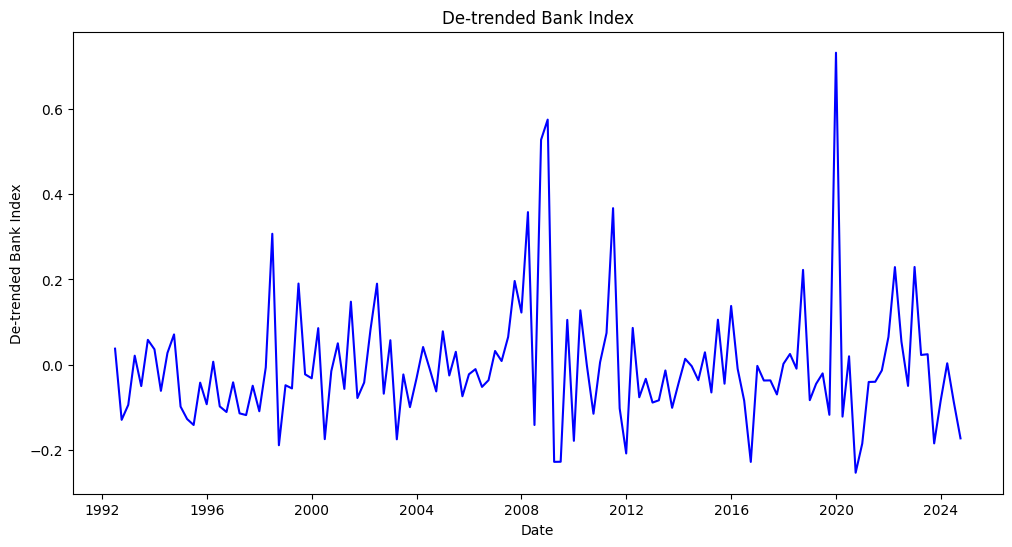

In [52]:
# plot the de-trended bank index:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Growth Rate Bank Index'], label='Bank Index', color='blue')
plt.title('De-trended Bank Index')
plt.xlabel('Date')
plt.ylabel('De-trended Bank Index')
plt.show()

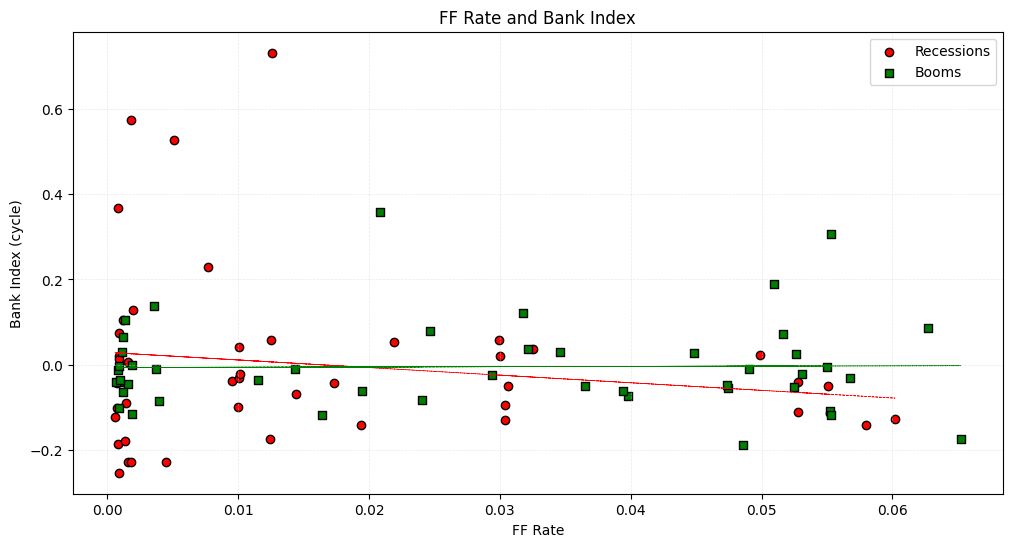

In [53]:
# make the same plot as above with 'Deposits' instead of 'Loans':
plt.figure(figsize=(12, 6))
plt.scatter(df[df['Recession']==1]['FEDFUNDS'], df[df['Recession']==1]['Growth Rate Bank Index'], label='Recessions', color='red', edgecolors='black')
x = df[df['Recession']==1]['FEDFUNDS']
y = df[df['Recession']==1]['Growth Rate Bank Index']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red', linestyle='--', linewidth=0.5)
plt.scatter(df[df['Recession']==0]['FEDFUNDS'], df[df['Recession']==0]['Growth Rate Bank Index'], label='Booms', color='green', edgecolors='black', marker='s')
x = df[df['Recession']==0]['FEDFUNDS']
y = df[df['Recession']==0]['Growth Rate Bank Index']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='green', linestyle='--', linewidth=0.5)
plt.title('FF Rate and Bank Index')
plt.xlabel('FF Rate')
plt.ylabel('Bank Index (cycle)')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.show()

In [54]:
# do the above regression using the OLS function from statsmodels:
X = sm.add_constant(df[df['Recession']==1]['FEDFUNDS'])
Y = df[df['Recession']==1]['Growth Rate Bank Index'].dropna()
model = sm.OLS(Y, X).fit()

# print the summary of the regression:
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     Growth Rate Bank Index   R-squared:                       0.028
Model:                                OLS   Adj. R-squared:                  0.005
Method:                     Least Squares   F-statistic:                     1.222
Date:                    Tue, 03 Dec 2024   Prob (F-statistic):              0.275
Time:                            11:35:01   Log-Likelihood:                 8.4095
No. Observations:                      45   AIC:                            -12.82
Df Residuals:                          43   BIC:                            -9.206
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

## Panel Data

In [55]:
# merge 'test' and 'main': 
df = pd.merge(test, main, on=['Date'], how='left')

In [56]:
# Create the variable 'Real Loans' and 'Real Deposits':
df['Real Loans'] = df['Loans'] / df['CPI'] * 100
df['Real Deposits'] = df['Deposits'] / df['CPI'] * 100

# create the 'Share Real Loans' and 'Share Real Deposits' per bank and date:
df['Share Real Loans'] = df['Real Loans'] / df['Agg. Real Loans'] *100
df['Share Real Deposits'] = df['Real Deposits'] / df['Agg. Real Deposits'] *100 

In [57]:
drop = df[(df['Real Deposits']==0) | (df['Real Loans']==0)]['IDRSSD'].unique()
df = df[~df['IDRSSD'].isin(drop)]

In [58]:
# compute the de-trended 'Real Loans' and 'Real Deposits' per ID, using an HP filter:
df['De-trended Real Loans'] = df.groupby('IDRSSD')['Real Loans'].transform(lambda x: sm.tsa.filters.hpfilter(np.log(x), lamb=param)[0])
df['De-trended Real Deposits'] = df.groupby('IDRSSD')['Real Deposits'].transform(lambda x: sm.tsa.filters.hpfilter(np.log(x), lamb=param)[0])

In [59]:
# compute the average FEDFUNDS per date, and accross all dates:
df['Average FF Rate'] = df.groupby('Date')['FEDFUNDS'].transform('mean')
df['Average FF Rate'] = df['Average FF Rate'].mean()

print('Avg. FedFunds Rate:',   df['Average FF Rate'].unique()[0])

# create a variable named 'FF Hike' as 1 if the FF rate increased, and 0 otherwise:
df['FF Hike'] = 0
df.loc[df['FEDFUNDS'] > df['FEDFUNDS'].shift(1), 'FF Hike'] = 1

Avg. FedFunds Rate: 0.035333123689727464


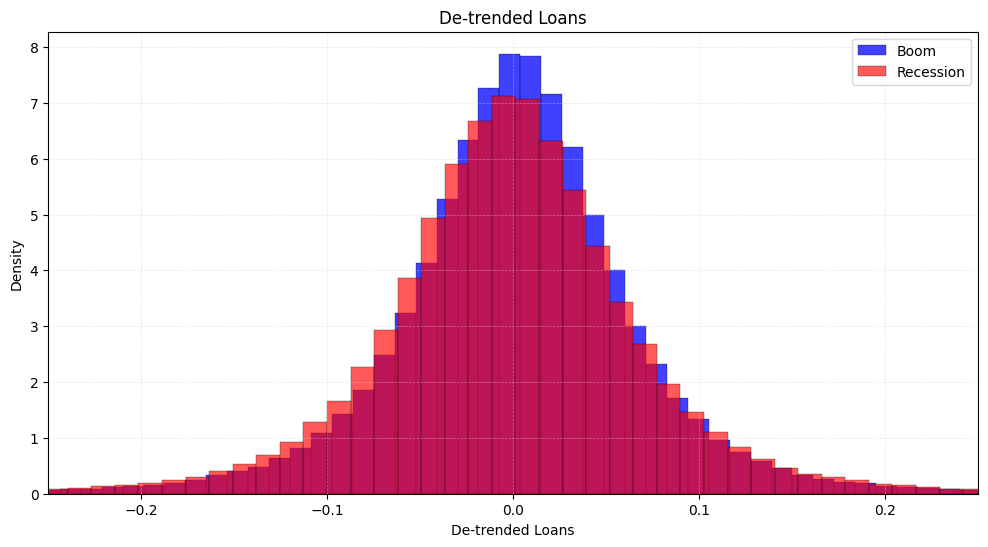

In [60]:
# plot a histogram of de-trended loans when the bank is in a recession and when it is not using plt.plot:
plt.figure(figsize=(12, 6))
sns.histplot(df[df['Recession']==0]['De-trended Real Loans'], label='Boom', color='blue', bins=300, stat='density')
sns.histplot(df[df['Recession']==1]['De-trended Real Loans'], label='Recession', color='red', bins=300, alpha=0.65, stat='density')
plt.title('De-trended Loans')
plt.xlabel('De-trended Loans')
plt.ylabel('Density')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.xlim(-0.25, 0.25)
plt.show() 
 

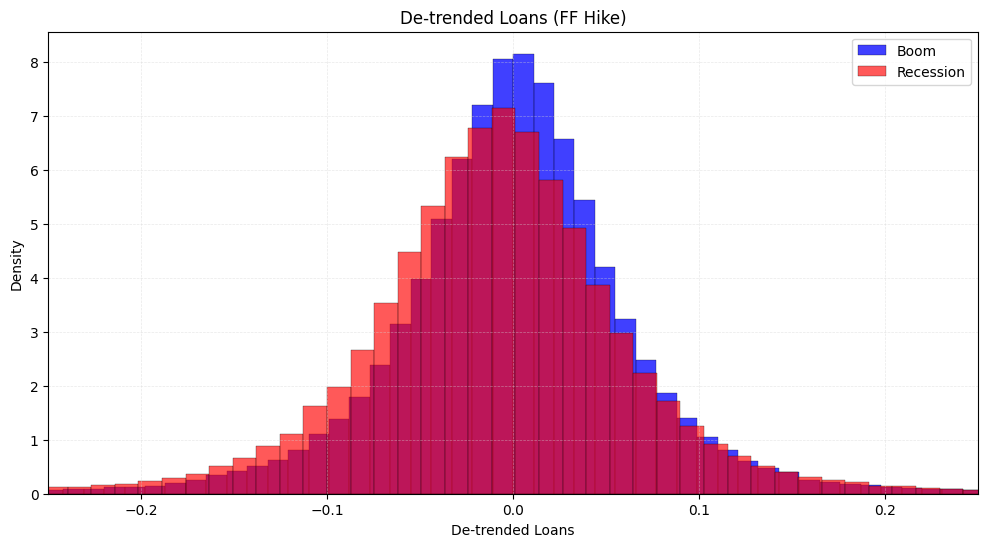

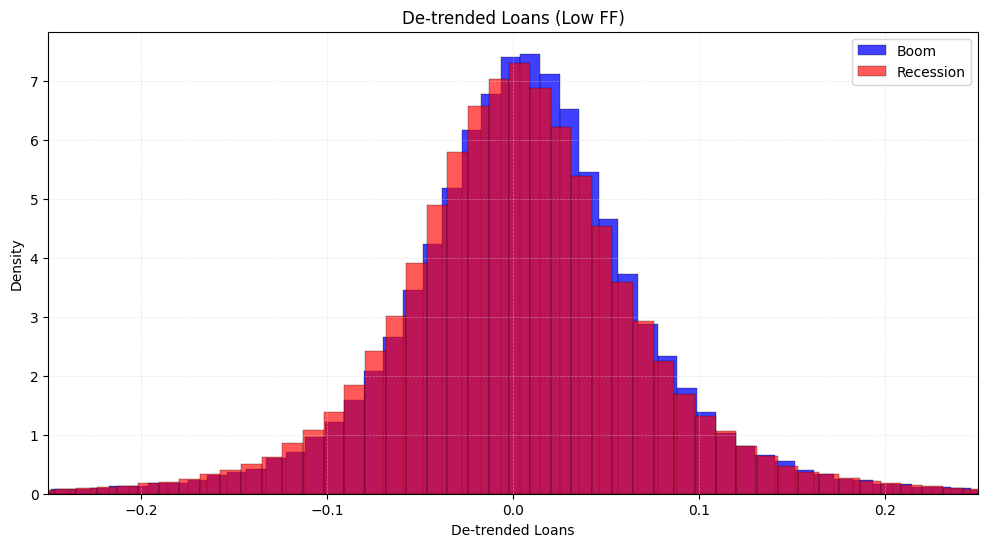

In [61]:
# plot a histogram of de-trended loans when the bank is in a recession and when it is not using plt.plot:
plt.figure(figsize=(12, 6))
sns.histplot(df[(df['Recession']==0) & (df['FF Hike']==1)]['De-trended Real Loans'], label='Boom', color='blue', bins=300, stat='density')
sns.histplot(df[(df['Recession']==1) & (df['FF Hike']==1)]['De-trended Real Loans'], label='Recession', color='red', bins=300, alpha=0.65, stat='density')
plt.title('De-trended Loans (FF Hike)')
plt.xlabel('De-trended Loans')
plt.ylabel('Density')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.xlim(-0.25, 0.25)
plt.show() 


plt.figure(figsize=(12, 6))
sns.histplot(df[(df['Recession']==0) & (df['FF Hike']==0)]['De-trended Real Loans'], label='Boom', color='blue', bins=300, stat='density')
sns.histplot(df[(df['Recession']==1) & (df['FF Hike']==0)]['De-trended Real Loans'], label='Recession', color='red', bins=300, alpha=0.65, stat='density')
plt.title('De-trended Loans (Low FF)')
plt.xlabel('De-trended Loans')
plt.ylabel('Density')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.xlim(-0.25, 0.25)
plt.show() 
 

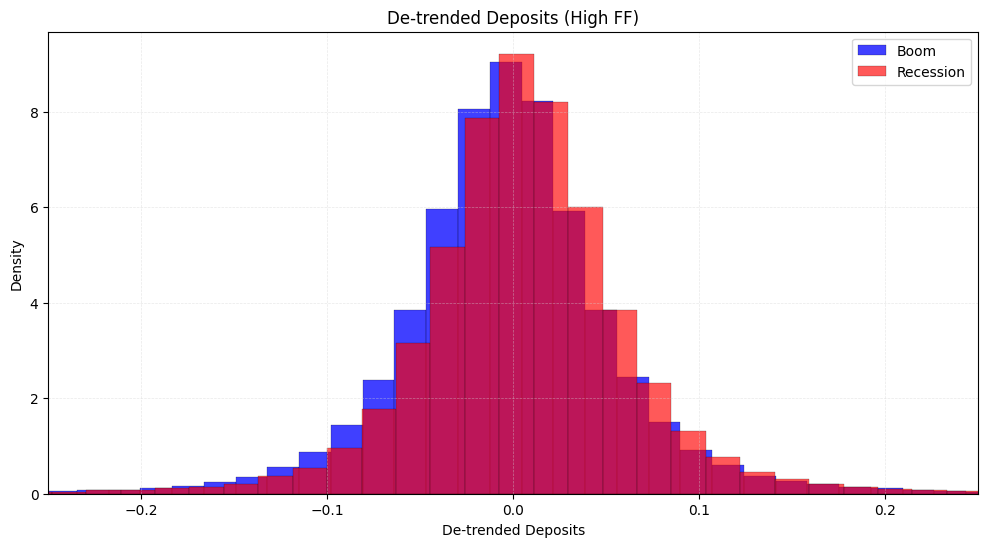

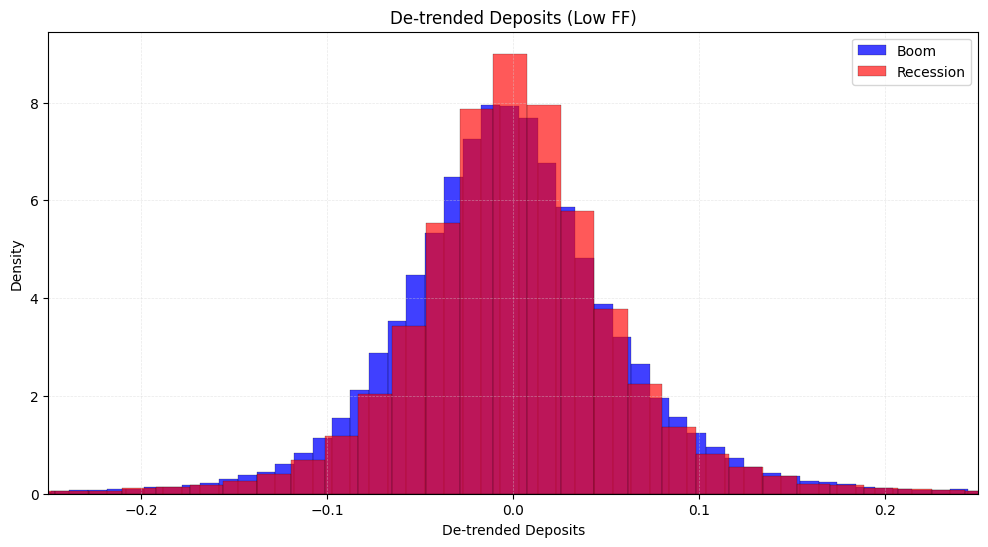

In [62]:
# plot a histogram of de-trended loans when the bank is in a recession and when it is not using plt.plot:
plt.figure(figsize=(12, 6))
sns.histplot(df[(df['Recession']==0) & (df['FF Hike']==1)]['De-trended Real Deposits'], label='Boom', color='blue', bins=400, stat='density')
sns.histplot(df[(df['Recession']==1) & (df['FF Hike']==1)]['De-trended Real Deposits'], label='Recession', color='red', bins=400, alpha=0.65, stat='density')
plt.title('De-trended Deposits (High FF)')
plt.xlabel('De-trended Deposits')
plt.ylabel('Density')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.xlim(-0.25, 0.25)
plt.show() 


plt.figure(figsize=(12, 6))
sns.histplot(df[(df['Recession']==0) & (df['FF Hike']==0)]['De-trended Real Deposits'], label='Boom', color='blue', bins=400, stat='density')
sns.histplot(df[(df['Recession']==1) & (df['FF Hike']==0)]['De-trended Real Deposits'], label='Recession', color='red', bins=400, alpha=0.65, stat='density')
plt.title('De-trended Deposits (Low FF)')
plt.xlabel('De-trended Deposits')
plt.ylabel('Density')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.xlim(-0.25, 0.25)
plt.show() 
 

In [63]:
# compute inflation as the growth rate of the CPI:
df['Inflation'] = df['CPI'].pct_change(fill_method=None)

# compute the average inflation in the whole sample:
print('The average quarterly inflation in the period was:',  df['Inflation'].mean()*100)

# create a variable named 'High Inflation' as 1 if the inflation is above the average, and 0 otherwise:
df['High Inflation'] = 0
df.loc[df['Inflation'] > df['Inflation'].mean(), 'High Inflation'] = 1

The average quarterly inflation in the period was: 0.2723930856692552


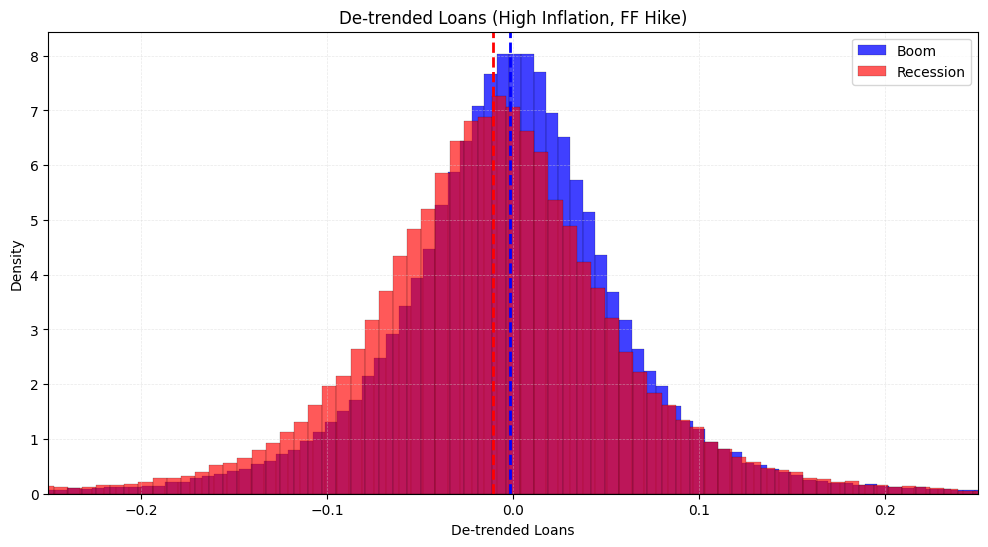

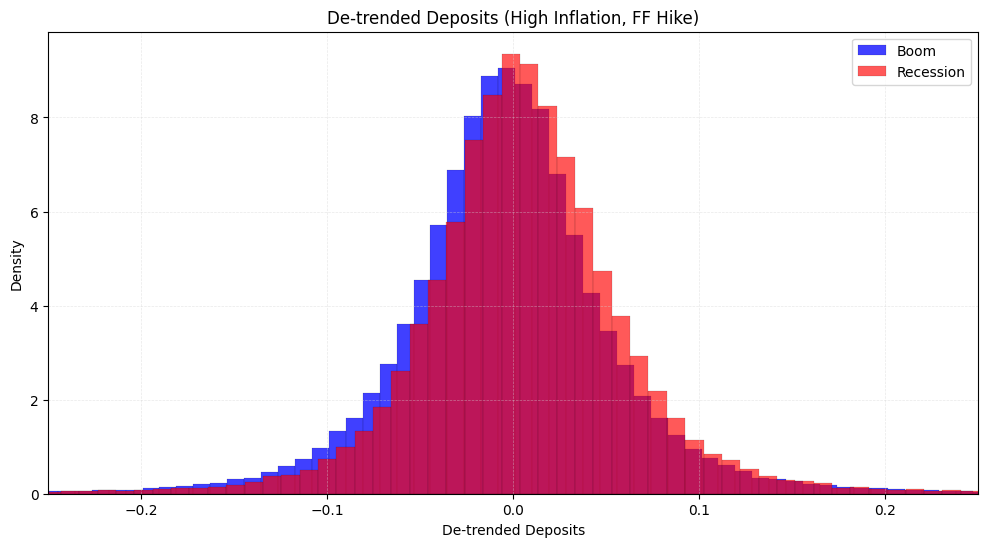

In [66]:
# make a histogram of the de-trended loans when the inflation is high, FF hike and Boom vs. Recession:
plt.figure(figsize=(12, 6))
sns.histplot(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['De-trended Real Loans'], label='Boom', color='blue', bins=500, stat='density')
sns.histplot(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['De-trended Real Loans'], label='Recession', color='red', bins=500, alpha=0.65, stat='density')
# plot the mean of both distributions:
plt.axvline(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['De-trended Real Loans'].mean(), color='blue', linestyle='--', linewidth=2)
plt.axvline(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['De-trended Real Loans'].mean(), color='red', linestyle='--', linewidth=2)
plt.title('De-trended Loans (High Inflation, FF Hike)')
plt.xlabel('De-trended Loans')
plt.ylabel('Density')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.xlim(-0.25, 0.25)
plt.savefig('Loans_Histogram.svg')
plt.show()


# make a histogram of the de-trended loans when the inflation is high, FF hike and Boom vs. Recession:
plt.figure(figsize=(12, 6))
sns.histplot(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==0)]['De-trended Real Deposits'], label='Boom', color='blue', bins=750, stat='density')
sns.histplot(df[(df['High Inflation']==1) & (df['FF Hike']==1) & (df['Recession']==1)]['De-trended Real Deposits'], label='Recession', color='red', bins=750, alpha=0.65, stat='density')
plt.title('De-trended Deposits (High Inflation, FF Hike)')
plt.xlabel('De-trended Deposits')
plt.ylabel('Density')
plt.legend()
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.xlim(-0.25, 0.25)

plt.show()

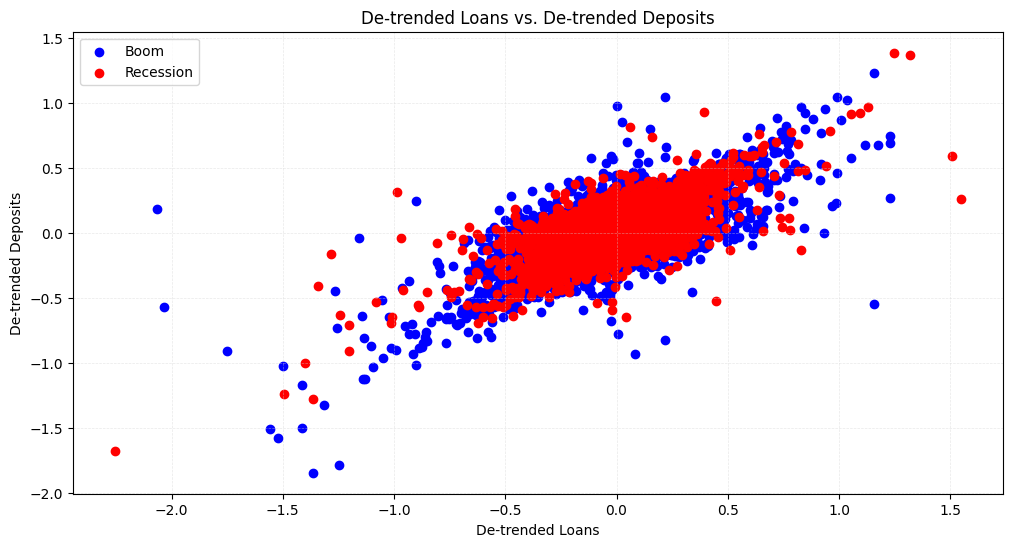

In [67]:
# make a scatter plot of the de-trended loans and the de-trended deposits using plt.plot:
plt.figure(figsize=(12, 6))
plt.scatter(df[(df['Recession']==0) & (df['FF Hike']==1) & (df['High Inflation']==1)]['De-trended Real Loans'], 
            df[(df['Recession']==0) & (df['FF Hike']==1) & (df['High Inflation']==1)]['De-trended Real Deposits'], color='blue', edgecolors='blue')

plt.scatter(df[(df['Recession']==1) & (df['FF Hike']==1) & (df['High Inflation']==1)]['De-trended Real Loans'], 
            df[(df['Recession']==1) & (df['FF Hike']==1) & (df['High Inflation']==1)]['De-trended Real Deposits'], color='red', edgecolors='red')
plt.title('De-trended Loans vs. De-trended Deposits')
plt.xlabel('De-trended Loans')
plt.ylabel('De-trended Deposits')
plt.legend(['Boom', 'Recession'])
plt.grid(True, which='both', linestyle='--', lw=0.5, alpha=0.5, color='lightgrey')
plt.savefig('Loans_Deposits_Scatter.svg')
plt.show()

Apparently, there is a mass of banks that lose loans during a _supply shock_ (histogram). This mass of banks appears to coincide with the banks that loose deposits (scatter). Our claim is that those banks are more exposed to hikes in interest rates. 